# IMAGE SEGMENTATION

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import os
import PIL


from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline

In [2]:
print("TensorFlow version: ",tf.__version__)

TensorFlow version:  2.7.0


Checking the available CPU and GPU devices

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
Num CPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Initial Preparation

### Train data

Setting the path to train images and masks.

In [4]:
train_x_loc = "../data/train_images/"
train_y_loc = "../data/train_masks/"

Extract the names of the image files and sort and store them in a list. This will later be iterated over to read and store the image and mask data.

In [5]:
img_names = [s[:-4] for s in os.listdir(train_x_loc)]

In order to prevent clogging up the RAM, we will create batches of images.

In [6]:
TRAIN_BATCH_SIZE = 100

In [7]:
img_names_batches = [img_names[i:i + TRAIN_BATCH_SIZE] for i in range(0, len(img_names), TRAIN_BATCH_SIZE)]
print("Train images were split into batches of size {}.".format(TRAIN_BATCH_SIZE))
print("Number of batches = ",len(img_names_batches))

Train images were split into batches of size 100.
Number of batches =  3


### Image Configs

In [8]:
INPUT_SIZE = 512
N_CHANNEL = 3
N_CLASSES = 27

## Model Creation

### UNet

In [9]:
def get_unet():
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.2)(pool1) # Dropout(0.2)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.2)(pool2) #Dropout(0.2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.2)(pool3) 

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.2)(pool4) # Dropout(0.2)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation="softmax")(conv9) #

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    return model

In semantic segmentation, you need as many masks as you have object classes. 
In our dataset, each pixel in every mask has been assigned a single integer probability that it belongs to a 
certain class - 0 to 26. The correct class is the one with the highest probability. 

Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with 
lots of classes and to perform pixel-wise multiclass prediction. 

## Training the model

### Creating CallBacks

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

In [10]:
# TensorBoard visuluaziations
# To visualize, execute the following commands in a new jupyter notebook:
# %load_ext tensorboard
# %tensorboard --logdir /tmp/tboard_logs8
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs8', histogram_freq=0, write_graph=True, write_images=True)

class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_batch_begin(self, batch, logs=None):
    print('\nTraining: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_train_batch_end(self, batch, logs=None):
    print('\nTraining: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_begin(self, batch, logs=None):
    print('\nEvaluating: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_end(self, batch, logs=None):
    print('\nEvaluating: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

### Training

In [11]:
# img_names_batches = [img_names_batches[0]]

In [12]:
print(len(img_names_batches[0]))
print(len(img_names_batches[1]))
print(len(img_names_batches[2]))

100
100
61


In [13]:
# Training configs
EPOCHS = 30
LEARNING_RATE = 0.001
CURRENT_SAVE_LOC = "saved_models/training_15/"

model = None

for img_names in img_names_batches:
    
    if len(img_names) > 90:
        EPOCHS = 35
        print(" EPOCHS set to ", EPOCHS)
    elif len(img_names) < 70:
        EPOCHS = 5
        print(" EPOCHS set to ", EPOCHS)
    else:
        EPOCHS = 20
        print(" EPOCHS set to ", EPOCHS)
    
    # Setting the model
    if model is None:
        print("No model set. Creating new model.")
        model = get_unet()
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])
        INITIAL_TRAIN = False
        print("UNet model created from scratch")
    else:
        model = tf.keras.models.load_model(CURRENT_SAVE_LOC)
        print("UNet model loaded from ", CURRENT_SAVE_LOC)
        
    if model is None:
            print("!!! MODEL NOT SET !!!")
            break
              
    # Preparing the data
    x = []
    y = []
    print("Reading train data")
    for i in img_names:
        x.append(np.array(PIL.Image.open(train_x_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255)
        y.append(to_categorical(np.array(PIL.Image.open(train_y_loc + i + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST)), N_CLASSES))
    x = np.array(x)
    y = np.array(y)
    # Reserve 20 samples for validation
    x_train = x[:-10]
    y_train = y[:-10]
    print("x train ---- ", len(x_train))
    x_val = x[-10:]
    print("x val ---- ", len(x_val))
    y_val = y[-10:]
    del x,y
    print("Train and Validation data created")
    

    # Training the model
    model.fit(x_train, y_train, batch_size=5, epochs=EPOCHS, validation_data=(x_val, y_val), shuffle=True, callbacks=[MyCustomCallback(),tensorboard])
    del x_train,y_train,x_val,y_val
    
    # Saving the model
    print("Saving the model")
    model.save(CURRENT_SAVE_LOC)
#     model.save(CURRENT_SAVE_LOC,save_format='h5')
    print("Saved the model at", CURRENT_SAVE_LOC)
    

 EPACHS set to  35
No model set. Creating new model.
Metal device set to: Apple M1


2022-01-08 14:44:34.720799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-08 14:44:34.720941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


UNet model created from scratch
Reading train data
x train ----  90
x val ----  10
Train and Validation data created


2022-01-08 14:44:52.455458: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/35

Training: batch 0 begins at 14:44:52.465432


2022-01-08 14:44:52.798527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Training: batch 0 ends at 14:44:54.890181
 1/18 [>.............................] - ETA: 41s - loss: 3.2037 - accuracy: 0.0703
Training: batch 1 begins at 14:44:54.909829

Training: batch 1 ends at 14:44:56.513972
 2/18 [==>...........................] - ETA: 25s - loss: 4.3631 - accuracy: 0.1129
Training: batch 2 begins at 14:44:56.515270

Training: batch 2 ends at 14:44:58.136202
 3/18 [====>.........................] - ETA: 24s - loss: 3.9715 - accuracy: 0.1273
Training: batch 3 begins at 14:44:58.137156

Training: batch 3 ends at 14:44:59.739699
 4/18 [=====>........................] - ETA: 22s - loss: 3.7609 - accuracy: 0.1273
Training: batch 4 begins at 14:44:59.740683

Training: batch 4 ends at 14:45:01.303258
 5/18 [=======>......................] - ETA: 20s - loss: 3.6309 - accuracy: 0.1298
Training: batch 5 begins at 14:45:01.304197

Training: batch 5 ends at 14:45:02.918449
 6/18 [=========>....................] - ETA: 19s - loss: 3.5468 - accuracy: 0.1288
Training: batch 6 

2022-01-08 14:45:22.374276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Evaluating: batch 0 ends at 14:45:22.928249

Evaluating: batch 1 begins at 14:45:22.928748

Evaluating: batch 1 ends at 14:45:23.398501
18/18 [==============================] - 31s 2s/step - loss: 3.0794 - accuracy: 0.2169 - val_loss: 2.2777 - val_accuracy: 0.3028
Epoch 2/35

Training: batch 0 begins at 14:45:23.408002

Training: batch 0 ends at 14:45:24.996054
 1/18 [>.............................] - ETA: 27s - loss: 2.5636 - accuracy: 0.2301
Training: batch 1 begins at 14:45:24.997053

Training: batch 1 ends at 14:45:26.568486
 2/18 [==>...........................] - ETA: 25s - loss: 2.4149 - accuracy: 0.2722
Training: batch 2 begins at 14:45:26.569465

Training: batch 2 ends at 14:45:28.180483
 3/18 [====>.........................] - ETA: 23s - loss: 2.4923 - accuracy: 0.2442
Training: batch 3 begins at 14:45:28.181463

Training: batch 3 ends at 14:45:29.776717
 4/18 [=====>........................] - ETA: 22s - loss: 2.4455 - accuracy: 0.2435
Training: batch 4 begins at 14:45:29.7

 7/18 [==========>...................] - ETA: 17s - loss: 1.9055 - accuracy: 0.3301
Training: batch 7 begins at 14:46:34.383258

Training: batch 7 ends at 14:46:35.997073
 8/18 [============>.................] - ETA: 15s - loss: 1.8971 - accuracy: 0.3230
Training: batch 8 begins at 14:46:35.998072

Training: batch 8 ends at 14:46:37.726634
 9/18 [==============>...............] - ETA: 14s - loss: 1.8786 - accuracy: 0.3114
Training: batch 9 begins at 14:46:37.727537

Training: batch 9 ends at 14:46:39.321355
10/18 [===============>..............] - ETA: 12s - loss: 1.8850 - accuracy: 0.3118
Training: batch 10 begins at 14:46:39.322294

Training: batch 10 ends at 14:46:40.986899
11/18 [=================>............] - ETA: 11s - loss: 1.8939 - accuracy: 0.3135
Training: batch 11 begins at 14:46:40.987973

Training: batch 11 ends at 14:46:42.603450
12/18 [===================>..........] - ETA: 9s - loss: 1.8796 - accuracy: 0.3232 
Training: batch 12 begins at 14:46:42.604585

Training: b

15/18 [========================>.....] - ETA: 4s - loss: 1.6683 - accuracy: 0.4244
Training: batch 15 begins at 14:47:47.153404

Training: batch 15 ends at 14:47:48.772631
16/18 [=========================>....] - ETA: 3s - loss: 1.6741 - accuracy: 0.4173
Training: batch 16 begins at 14:47:48.773555

Training: batch 16 ends at 14:47:50.367787
17/18 [===========================>..] - ETA: 1s - loss: 1.6821 - accuracy: 0.4143
Training: batch 17 begins at 14:47:50.368942

Training: batch 17 ends at 14:47:51.959016
18/18 [==============================] - ETA: 0s - loss: 1.6789 - accuracy: 0.4142
Evaluating: batch 0 begins at 14:47:51.970342

Evaluating: batch 0 ends at 14:47:52.504386

Evaluating: batch 1 begins at 14:47:52.505021

Evaluating: batch 1 ends at 14:47:52.985392
18/18 [==============================] - 30s 2s/step - loss: 1.6789 - accuracy: 0.4142 - val_loss: 1.6184 - val_accuracy: 0.4049
Epoch 7/35

Training: batch 0 begins at 14:47:52.995409

Training: batch 0 ends at 14:47:

 3/18 [====>.........................] - ETA: 24s - loss: 1.7003 - accuracy: 0.3613
Training: batch 3 begins at 14:48:57.505155

Training: batch 3 ends at 14:48:59.091317
 4/18 [=====>........................] - ETA: 22s - loss: 1.6496 - accuracy: 0.3880
Training: batch 4 begins at 14:48:59.092329

Training: batch 4 ends at 14:49:00.669414
 5/18 [=======>......................] - ETA: 20s - loss: 1.6486 - accuracy: 0.3956
Training: batch 5 begins at 14:49:00.671215

Training: batch 5 ends at 14:49:02.278255
 6/18 [=========>....................] - ETA: 19s - loss: 1.6653 - accuracy: 0.4159
Training: batch 6 begins at 14:49:02.279217

Training: batch 6 ends at 14:49:03.891612
 7/18 [==========>...................] - ETA: 17s - loss: 1.6600 - accuracy: 0.4215
Training: batch 7 begins at 14:49:03.892535

Training: batch 7 ends at 14:49:05.502918
 8/18 [============>.................] - ETA: 16s - loss: 1.6840 - accuracy: 0.4051
Training: batch 8 begins at 14:49:05.504721

Training: batch 

11/18 [=================>............] - ETA: 11s - loss: 1.5877 - accuracy: 0.4652
Training: batch 11 begins at 14:50:09.972104

Training: batch 11 ends at 14:50:11.569612
12/18 [===================>..........] - ETA: 9s - loss: 1.5701 - accuracy: 0.4712 
Training: batch 12 begins at 14:50:11.571347

Training: batch 12 ends at 14:50:13.165455
13/18 [====================>.........] - ETA: 7s - loss: 1.5525 - accuracy: 0.4749
Training: batch 13 begins at 14:50:13.166617

Training: batch 13 ends at 14:50:14.745123
14/18 [======================>.......] - ETA: 6s - loss: 1.5370 - accuracy: 0.4835
Training: batch 14 begins at 14:50:14.746156

Training: batch 14 ends at 14:50:16.332438
15/18 [========================>.....] - ETA: 4s - loss: 1.5298 - accuracy: 0.4848
Training: batch 15 begins at 14:50:16.333378

Training: batch 15 ends at 14:50:17.929703
16/18 [=========================>....] - ETA: 3s - loss: 1.5375 - accuracy: 0.4786
Training: batch 16 begins at 14:50:17.931538

Training:


Evaluating: batch 1 ends at 14:51:21.880962
18/18 [==============================] - 30s 2s/step - loss: 1.5130 - accuracy: 0.4927 - val_loss: 1.7093 - val_accuracy: 0.3528
Epoch 14/35

Training: batch 0 begins at 14:51:21.890868

Training: batch 0 ends at 14:51:23.499105
 1/18 [>.............................] - ETA: 27s - loss: 1.6616 - accuracy: 0.4812
Training: batch 1 begins at 14:51:23.500015

Training: batch 1 ends at 14:51:25.105179
 2/18 [==>...........................] - ETA: 25s - loss: 1.5241 - accuracy: 0.4978
Training: batch 2 begins at 14:51:25.106116

Training: batch 2 ends at 14:51:26.710279
 3/18 [====>.........................] - ETA: 24s - loss: 1.5145 - accuracy: 0.4763
Training: batch 3 begins at 14:51:26.711197

Training: batch 3 ends at 14:51:28.301407
 4/18 [=====>........................] - ETA: 22s - loss: 1.5077 - accuracy: 0.5026
Training: batch 4 begins at 14:51:28.302356

Training: batch 4 ends at 14:51:29.901437
 5/18 [=======>......................] - E

 7/18 [==========>...................] - ETA: 17s - loss: 1.4529 - accuracy: 0.5098
Training: batch 7 begins at 14:52:32.989314

Training: batch 7 ends at 14:52:34.584678
 8/18 [============>.................] - ETA: 16s - loss: 1.4610 - accuracy: 0.5056
Training: batch 8 begins at 14:52:34.585634

Training: batch 8 ends at 14:52:36.193162
 9/18 [==============>...............] - ETA: 14s - loss: 1.4640 - accuracy: 0.5023
Training: batch 9 begins at 14:52:36.194312

Training: batch 9 ends at 14:52:37.796067
10/18 [===============>..............] - ETA: 12s - loss: 1.4427 - accuracy: 0.5135
Training: batch 10 begins at 14:52:37.796954

Training: batch 10 ends at 14:52:39.456570
11/18 [=================>............] - ETA: 11s - loss: 1.4570 - accuracy: 0.5161
Training: batch 11 begins at 14:52:39.457461

Training: batch 11 ends at 14:52:41.091552
12/18 [===================>..........] - ETA: 9s - loss: 1.4476 - accuracy: 0.5148 
Training: batch 12 begins at 14:52:41.092589

Training: b

15/18 [========================>.....] - ETA: 4s - loss: 1.4794 - accuracy: 0.5049
Training: batch 15 begins at 14:53:45.415259

Training: batch 15 ends at 14:53:47.019967
16/18 [=========================>....] - ETA: 3s - loss: 1.4830 - accuracy: 0.5000
Training: batch 16 begins at 14:53:47.020934

Training: batch 16 ends at 14:53:48.592135
17/18 [===========================>..] - ETA: 1s - loss: 1.4658 - accuracy: 0.5076
Training: batch 17 begins at 14:53:48.593112

Training: batch 17 ends at 14:53:50.185729
18/18 [==============================] - ETA: 0s - loss: 1.4667 - accuracy: 0.5101
Evaluating: batch 0 begins at 14:53:50.196147

Evaluating: batch 0 ends at 14:53:50.719227

Evaluating: batch 1 begins at 14:53:50.719722

Evaluating: batch 1 ends at 14:53:51.196433
18/18 [==============================] - 30s 2s/step - loss: 1.4667 - accuracy: 0.5101 - val_loss: 1.4908 - val_accuracy: 0.4512
Epoch 19/35

Training: batch 0 begins at 14:53:51.206517

Training: batch 0 ends at 14:53

 3/18 [====>.........................] - ETA: 23s - loss: 1.2901 - accuracy: 0.5934
Training: batch 3 begins at 14:54:55.646787

Training: batch 3 ends at 14:54:57.244939
 4/18 [=====>........................] - ETA: 22s - loss: 1.3351 - accuracy: 0.5818
Training: batch 4 begins at 14:54:57.245897

Training: batch 4 ends at 14:54:58.831510
 5/18 [=======>......................] - ETA: 20s - loss: 1.3475 - accuracy: 0.5802
Training: batch 5 begins at 14:54:58.832737

Training: batch 5 ends at 14:55:00.412216
 6/18 [=========>....................] - ETA: 19s - loss: 1.3533 - accuracy: 0.5681
Training: batch 6 begins at 14:55:00.413219

Training: batch 6 ends at 14:55:02.018804
 7/18 [==========>...................] - ETA: 17s - loss: 1.3777 - accuracy: 0.5477
Training: batch 7 begins at 14:55:02.019828

Training: batch 7 ends at 14:55:03.614367
 8/18 [============>.................] - ETA: 15s - loss: 1.3511 - accuracy: 0.5579
Training: batch 8 begins at 14:55:03.615286

Training: batch 

11/18 [=================>............] - ETA: 11s - loss: 1.2604 - accuracy: 0.5554
Training: batch 11 begins at 14:56:07.710903

Training: batch 11 ends at 14:56:09.295063
12/18 [===================>..........] - ETA: 9s - loss: 1.2882 - accuracy: 0.5440 
Training: batch 12 begins at 14:56:09.296039

Training: batch 12 ends at 14:56:10.875440
13/18 [====================>.........] - ETA: 7s - loss: 1.3119 - accuracy: 0.5388
Training: batch 13 begins at 14:56:10.876504

Training: batch 13 ends at 14:56:12.470644
14/18 [======================>.......] - ETA: 6s - loss: 1.3102 - accuracy: 0.5419
Training: batch 14 begins at 14:56:12.471557

Training: batch 14 ends at 14:56:14.053222
15/18 [========================>.....] - ETA: 4s - loss: 1.2984 - accuracy: 0.5457
Training: batch 15 begins at 14:56:14.054234

Training: batch 15 ends at 14:56:15.641205
16/18 [=========================>....] - ETA: 3s - loss: 1.3147 - accuracy: 0.5443
Training: batch 16 begins at 14:56:15.642225

Training:


Evaluating: batch 1 ends at 14:57:19.300904
18/18 [==============================] - 30s 2s/step - loss: 1.3280 - accuracy: 0.5425 - val_loss: 1.2860 - val_accuracy: 0.5752
Epoch 26/35

Training: batch 0 begins at 14:57:19.310820

Training: batch 0 ends at 14:57:20.902034
 1/18 [>.............................] - ETA: 27s - loss: 1.4181 - accuracy: 0.5434
Training: batch 1 begins at 14:57:20.903071

Training: batch 1 ends at 14:57:22.510915
 2/18 [==>...........................] - ETA: 25s - loss: 1.3559 - accuracy: 0.5800
Training: batch 2 begins at 14:57:22.511841

Training: batch 2 ends at 14:57:24.099345
 3/18 [====>.........................] - ETA: 23s - loss: 1.3367 - accuracy: 0.5695
Training: batch 3 begins at 14:57:24.100351

Training: batch 3 ends at 14:57:25.704059
 4/18 [=====>........................] - ETA: 22s - loss: 1.3131 - accuracy: 0.5726
Training: batch 4 begins at 14:57:25.705357

Training: batch 4 ends at 14:57:27.291839
 5/18 [=======>......................] - E

 7/18 [==========>...................] - ETA: 17s - loss: 1.2405 - accuracy: 0.5989
Training: batch 7 begins at 14:58:29.919598

Training: batch 7 ends at 14:58:31.481879
 8/18 [============>.................] - ETA: 15s - loss: 1.2601 - accuracy: 0.5859
Training: batch 8 begins at 14:58:31.482928

Training: batch 8 ends at 14:58:33.065299
 9/18 [==============>...............] - ETA: 14s - loss: 1.2571 - accuracy: 0.5815
Training: batch 9 begins at 14:58:33.066290

Training: batch 9 ends at 14:58:34.647181
10/18 [===============>..............] - ETA: 12s - loss: 1.2680 - accuracy: 0.5749
Training: batch 10 begins at 14:58:34.648229

Training: batch 10 ends at 14:58:36.239978
11/18 [=================>............] - ETA: 11s - loss: 1.2919 - accuracy: 0.5682
Training: batch 11 begins at 14:58:36.240948

Training: batch 11 ends at 14:58:37.846848
12/18 [===================>..........] - ETA: 9s - loss: 1.2894 - accuracy: 0.5686 
Training: batch 12 begins at 14:58:37.847878

Training: b

15/18 [========================>.....] - ETA: 4s - loss: 1.2624 - accuracy: 0.5594
Training: batch 15 begins at 14:59:42.054535

Training: batch 15 ends at 14:59:43.658927
16/18 [=========================>....] - ETA: 3s - loss: 1.2730 - accuracy: 0.5576
Training: batch 16 begins at 14:59:43.660139

Training: batch 16 ends at 14:59:45.246757
17/18 [===========================>..] - ETA: 1s - loss: 1.2765 - accuracy: 0.5561
Training: batch 17 begins at 14:59:45.247745

Training: batch 17 ends at 14:59:46.842062
18/18 [==============================] - ETA: 0s - loss: 1.2682 - accuracy: 0.5632
Evaluating: batch 0 begins at 14:59:46.852324

Evaluating: batch 0 ends at 14:59:47.380136

Evaluating: batch 1 begins at 14:59:47.380660

Evaluating: batch 1 ends at 14:59:47.855745
18/18 [==============================] - 30s 2s/step - loss: 1.2682 - accuracy: 0.5632 - val_loss: 1.2581 - val_accuracy: 0.5687
Epoch 31/35

Training: batch 0 begins at 14:59:47.865784

Training: batch 0 ends at 14:59

 3/18 [====>.........................] - ETA: 23s - loss: 1.1422 - accuracy: 0.6066
Training: batch 3 begins at 15:00:52.164290

Training: batch 3 ends at 15:00:53.765194
 4/18 [=====>........................] - ETA: 22s - loss: 1.1669 - accuracy: 0.5970
Training: batch 4 begins at 15:00:53.766182

Training: batch 4 ends at 15:00:55.373355
 5/18 [=======>......................] - ETA: 20s - loss: 1.2054 - accuracy: 0.5763
Training: batch 5 begins at 15:00:55.374769

Training: batch 5 ends at 15:00:56.991828
 6/18 [=========>....................] - ETA: 19s - loss: 1.2457 - accuracy: 0.5710
Training: batch 6 begins at 15:00:56.992846

Training: batch 6 ends at 15:00:58.583793
 7/18 [==========>...................] - ETA: 17s - loss: 1.2505 - accuracy: 0.5662
Training: batch 7 begins at 15:00:58.584712

Training: batch 7 ends at 15:01:00.177487
 8/18 [============>.................] - ETA: 15s - loss: 1.2342 - accuracy: 0.5690
Training: batch 8 begins at 15:01:00.178485

Training: batch 

11/18 [=================>............] - ETA: 11s - loss: 1.2298 - accuracy: 0.5832
Training: batch 11 begins at 15:02:04.375961

Training: batch 11 ends at 15:02:05.959789
12/18 [===================>..........] - ETA: 9s - loss: 1.2672 - accuracy: 0.5741 
Training: batch 12 begins at 15:02:05.960767

Training: batch 12 ends at 15:02:07.522202
13/18 [====================>.........] - ETA: 7s - loss: 1.2682 - accuracy: 0.5709
Training: batch 13 begins at 15:02:07.523211

Training: batch 13 ends at 15:02:09.091138
14/18 [======================>.......] - ETA: 6s - loss: 1.2648 - accuracy: 0.5663
Training: batch 14 begins at 15:02:09.092187

Training: batch 14 ends at 15:02:10.675662
15/18 [========================>.....] - ETA: 4s - loss: 1.2605 - accuracy: 0.5677
Training: batch 15 begins at 15:02:10.676604

Training: batch 15 ends at 15:02:12.263995
16/18 [=========================>....] - ETA: 3s - loss: 1.2677 - accuracy: 0.5657
Training: batch 16 begins at 15:02:12.264996

Training:

2022-01-08 15:02:16.928665: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/training_15/assets
Saved the model at saved_models/training_15/
 EPACHS set to  35
UNet model loaded from  saved_models/training_15/
Reading train data
x train ----  90
x val ----  10
Train and Validation data created
Epoch 1/35

Training: batch 0 begins at 15:02:37.134705


2022-01-08 15:02:37.429658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Training: batch 0 ends at 15:02:39.684303
 1/18 [>.............................] - ETA: 43s - loss: 1.0518 - accuracy: 0.6406
Training: batch 1 begins at 15:02:39.701202

Training: batch 1 ends at 15:02:41.292446
 2/18 [==>...........................] - ETA: 25s - loss: 1.5610 - accuracy: 0.5156
Training: batch 2 begins at 15:02:41.293439

Training: batch 2 ends at 15:02:42.903549
 3/18 [====>.........................] - ETA: 24s - loss: 1.4916 - accuracy: 0.5090
Training: batch 3 begins at 15:02:42.904538

Training: batch 3 ends at 15:02:44.449159
 4/18 [=====>........................] - ETA: 22s - loss: 1.4339 - accuracy: 0.5232
Training: batch 4 begins at 15:02:44.450182

Training: batch 4 ends at 15:02:46.039003
 5/18 [=======>......................] - ETA: 20s - loss: 1.4333 - accuracy: 0.5176
Training: batch 5 begins at 15:02:46.040028

Training: batch 5 ends at 15:02:47.635543
 6/18 [=========>....................] - ETA: 19s - loss: 1.4246 - accuracy: 0.5210
Training: batch 6 

2022-01-08 15:03:06.836079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Evaluating: batch 0 ends at 15:03:07.394398

Evaluating: batch 1 begins at 15:03:07.394921

Evaluating: batch 1 ends at 15:03:07.870959
18/18 [==============================] - 31s 2s/step - loss: 1.4254 - accuracy: 0.5207 - val_loss: 1.3508 - val_accuracy: 0.5333
Epoch 2/35

Training: batch 0 begins at 15:03:07.880690

Training: batch 0 ends at 15:03:09.484975
 1/18 [>.............................] - ETA: 27s - loss: 1.3899 - accuracy: 0.4941
Training: batch 1 begins at 15:03:09.486132

Training: batch 1 ends at 15:03:11.076772
 2/18 [==>...........................] - ETA: 25s - loss: 1.2920 - accuracy: 0.5024
Training: batch 2 begins at 15:03:11.077905

Training: batch 2 ends at 15:03:12.682935
 3/18 [====>.........................] - ETA: 23s - loss: 1.4152 - accuracy: 0.4543
Training: batch 3 begins at 15:03:12.683970

Training: batch 3 ends at 15:03:14.253313
 4/18 [=====>........................] - ETA: 22s - loss: 1.4670 - accuracy: 0.4324
Training: batch 4 begins at 15:03:14.2

 7/18 [==========>...................] - ETA: 17s - loss: 1.1884 - accuracy: 0.5905
Training: batch 7 begins at 15:04:18.553094

Training: batch 7 ends at 15:04:20.146913
 8/18 [============>.................] - ETA: 16s - loss: 1.1833 - accuracy: 0.5876
Training: batch 8 begins at 15:04:20.147979

Training: batch 8 ends at 15:04:21.788699
 9/18 [==============>...............] - ETA: 14s - loss: 1.1996 - accuracy: 0.5878
Training: batch 9 begins at 15:04:21.789803

Training: batch 9 ends at 15:04:23.378777
10/18 [===============>..............] - ETA: 12s - loss: 1.2194 - accuracy: 0.5759
Training: batch 10 begins at 15:04:23.379914

Training: batch 10 ends at 15:04:24.968259
11/18 [=================>............] - ETA: 11s - loss: 1.2243 - accuracy: 0.5711
Training: batch 11 begins at 15:04:24.969349

Training: batch 11 ends at 15:04:26.575687
12/18 [===================>..........] - ETA: 9s - loss: 1.2183 - accuracy: 0.5741 
Training: batch 12 begins at 15:04:26.577162

Training: b

15/18 [========================>.....] - ETA: 4s - loss: 1.1486 - accuracy: 0.5961
Training: batch 15 begins at 15:05:30.901253

Training: batch 15 ends at 15:05:32.499576
16/18 [=========================>....] - ETA: 3s - loss: 1.1373 - accuracy: 0.6008
Training: batch 16 begins at 15:05:32.500604

Training: batch 16 ends at 15:05:34.100597
17/18 [===========================>..] - ETA: 1s - loss: 1.1456 - accuracy: 0.5964
Training: batch 17 begins at 15:05:34.101842

Training: batch 17 ends at 15:05:35.692146
18/18 [==============================] - ETA: 0s - loss: 1.1598 - accuracy: 0.5967
Evaluating: batch 0 begins at 15:05:35.700684

Evaluating: batch 0 ends at 15:05:36.226086

Evaluating: batch 1 begins at 15:05:36.226621

Evaluating: batch 1 ends at 15:05:36.702190
18/18 [==============================] - 30s 2s/step - loss: 1.1598 - accuracy: 0.5967 - val_loss: 1.2171 - val_accuracy: 0.5805
Epoch 7/35

Training: batch 0 begins at 15:05:36.712023

Training: batch 0 ends at 15:05:

 3/18 [====>.........................] - ETA: 24s - loss: 1.3221 - accuracy: 0.5327
Training: batch 3 begins at 15:06:41.067089

Training: batch 3 ends at 15:06:42.640902
 4/18 [=====>........................] - ETA: 22s - loss: 1.2715 - accuracy: 0.5418
Training: batch 4 begins at 15:06:42.641976

Training: batch 4 ends at 15:06:44.238378
 5/18 [=======>......................] - ETA: 20s - loss: 1.2954 - accuracy: 0.5457
Training: batch 5 begins at 15:06:44.239507

Training: batch 5 ends at 15:06:45.827989
 6/18 [=========>....................] - ETA: 19s - loss: 1.2594 - accuracy: 0.5581
Training: batch 6 begins at 15:06:45.829022

Training: batch 6 ends at 15:06:47.435740
 7/18 [==========>...................] - ETA: 17s - loss: 1.2564 - accuracy: 0.5610
Training: batch 7 begins at 15:06:47.436817

Training: batch 7 ends at 15:06:49.023190
 8/18 [============>.................] - ETA: 15s - loss: 1.2064 - accuracy: 0.5837
Training: batch 8 begins at 15:06:49.024410

Training: batch 

11/18 [=================>............] - ETA: 11s - loss: 1.1255 - accuracy: 0.6182
Training: batch 11 begins at 15:07:53.185024

Training: batch 11 ends at 15:07:54.797215
12/18 [===================>..........] - ETA: 9s - loss: 1.1148 - accuracy: 0.6204 
Training: batch 12 begins at 15:07:54.798284

Training: batch 12 ends at 15:07:56.398976
13/18 [====================>.........] - ETA: 7s - loss: 1.1083 - accuracy: 0.6247
Training: batch 13 begins at 15:07:56.400055

Training: batch 13 ends at 15:07:57.990795
14/18 [======================>.......] - ETA: 6s - loss: 1.1047 - accuracy: 0.6205
Training: batch 14 begins at 15:07:57.991871

Training: batch 14 ends at 15:07:59.591746
15/18 [========================>.....] - ETA: 4s - loss: 1.1138 - accuracy: 0.6160
Training: batch 15 begins at 15:07:59.592816

Training: batch 15 ends at 15:08:01.196264
16/18 [=========================>....] - ETA: 3s - loss: 1.1302 - accuracy: 0.6096
Training: batch 16 begins at 15:08:01.197328

Training:


Evaluating: batch 1 ends at 15:09:04.772070
18/18 [==============================] - 30s 2s/step - loss: 1.0599 - accuracy: 0.6402 - val_loss: 1.0554 - val_accuracy: 0.6322
Epoch 14/35

Training: batch 0 begins at 15:09:04.782106

Training: batch 0 ends at 15:09:06.394879
 1/18 [>.............................] - ETA: 27s - loss: 0.8283 - accuracy: 0.7124
Training: batch 1 begins at 15:09:06.395886

Training: batch 1 ends at 15:09:07.993591
 2/18 [==>...........................] - ETA: 25s - loss: 0.8949 - accuracy: 0.6654
Training: batch 2 begins at 15:09:07.994672

Training: batch 2 ends at 15:09:09.588495
 3/18 [====>.........................] - ETA: 23s - loss: 0.8590 - accuracy: 0.6894
Training: batch 3 begins at 15:09:09.589640

Training: batch 3 ends at 15:09:11.172796
 4/18 [=====>........................] - ETA: 22s - loss: 0.8733 - accuracy: 0.6812
Training: batch 4 begins at 15:09:11.173975

Training: batch 4 ends at 15:09:12.774221
 5/18 [=======>......................] - E

 7/18 [==========>...................] - ETA: 17s - loss: 1.0366 - accuracy: 0.6319
Training: batch 7 begins at 15:10:15.839769

Training: batch 7 ends at 15:10:17.447628
 8/18 [============>.................] - ETA: 16s - loss: 1.0340 - accuracy: 0.6350
Training: batch 8 begins at 15:10:17.448697

Training: batch 8 ends at 15:10:19.030934
 9/18 [==============>...............] - ETA: 14s - loss: 1.0296 - accuracy: 0.6366
Training: batch 9 begins at 15:10:19.032097

Training: batch 9 ends at 15:10:20.632745
10/18 [===============>..............] - ETA: 12s - loss: 1.0274 - accuracy: 0.6356
Training: batch 10 begins at 15:10:20.633818

Training: batch 10 ends at 15:10:22.213876
11/18 [=================>............] - ETA: 11s - loss: 1.0218 - accuracy: 0.6395
Training: batch 11 begins at 15:10:22.214889

Training: batch 11 ends at 15:10:23.823206
12/18 [===================>..........] - ETA: 9s - loss: 1.0164 - accuracy: 0.6388 
Training: batch 12 begins at 15:10:23.824268

Training: b

15/18 [========================>.....] - ETA: 4s - loss: 0.9525 - accuracy: 0.6736
Training: batch 15 begins at 15:11:28.097344

Training: batch 15 ends at 15:11:29.713370
16/18 [=========================>....] - ETA: 3s - loss: 0.9546 - accuracy: 0.6696
Training: batch 16 begins at 15:11:29.714407

Training: batch 16 ends at 15:11:31.331056
17/18 [===========================>..] - ETA: 1s - loss: 0.9448 - accuracy: 0.6736
Training: batch 17 begins at 15:11:31.332082

Training: batch 17 ends at 15:11:32.913994
18/18 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6664
Evaluating: batch 0 begins at 15:11:32.922977

Evaluating: batch 0 ends at 15:11:33.442206

Evaluating: batch 1 begins at 15:11:33.442710

Evaluating: batch 1 ends at 15:11:33.929551
18/18 [==============================] - 30s 2s/step - loss: 0.9607 - accuracy: 0.6664 - val_loss: 1.0190 - val_accuracy: 0.6687
Epoch 19/35

Training: batch 0 begins at 15:11:33.940557

Training: batch 0 ends at 15:11

 3/18 [====>.........................] - ETA: 23s - loss: 1.0007 - accuracy: 0.6549
Training: batch 3 begins at 15:12:38.087779

Training: batch 3 ends at 15:12:39.674437
 4/18 [=====>........................] - ETA: 22s - loss: 0.9698 - accuracy: 0.6640
Training: batch 4 begins at 15:12:39.675528

Training: batch 4 ends at 15:12:41.262891
 5/18 [=======>......................] - ETA: 20s - loss: 1.0045 - accuracy: 0.6491
Training: batch 5 begins at 15:12:41.264039

Training: batch 5 ends at 15:12:42.837376
 6/18 [=========>....................] - ETA: 19s - loss: 0.9678 - accuracy: 0.6610
Training: batch 6 begins at 15:12:42.838499

Training: batch 6 ends at 15:12:44.435553
 7/18 [==========>...................] - ETA: 17s - loss: 0.9665 - accuracy: 0.6665
Training: batch 7 begins at 15:12:44.436823

Training: batch 7 ends at 15:12:46.028230
 8/18 [============>.................] - ETA: 15s - loss: 0.9435 - accuracy: 0.6764
Training: batch 8 begins at 15:12:46.029325

Training: batch 

11/18 [=================>............] - ETA: 11s - loss: 0.8928 - accuracy: 0.6965
Training: batch 11 begins at 15:13:50.096157

Training: batch 11 ends at 15:13:51.682747
12/18 [===================>..........] - ETA: 9s - loss: 0.8758 - accuracy: 0.7018 
Training: batch 12 begins at 15:13:51.683857

Training: batch 12 ends at 15:13:53.265813
13/18 [====================>.........] - ETA: 7s - loss: 0.8777 - accuracy: 0.7005
Training: batch 13 begins at 15:13:53.266938

Training: batch 13 ends at 15:13:54.872797
14/18 [======================>.......] - ETA: 6s - loss: 0.8772 - accuracy: 0.6967
Training: batch 14 begins at 15:13:54.873907

Training: batch 14 ends at 15:13:56.467646
15/18 [========================>.....] - ETA: 4s - loss: 0.9121 - accuracy: 0.6885
Training: batch 15 begins at 15:13:56.468715

Training: batch 15 ends at 15:13:58.071010
16/18 [=========================>....] - ETA: 3s - loss: 0.9126 - accuracy: 0.6893
Training: batch 16 begins at 15:13:58.072007

Training:


Evaluating: batch 1 ends at 15:15:01.437754
18/18 [==============================] - 30s 2s/step - loss: 0.9907 - accuracy: 0.6588 - val_loss: 1.6741 - val_accuracy: 0.6326
Epoch 26/35

Training: batch 0 begins at 15:15:01.447661

Training: batch 0 ends at 15:15:03.051677
 1/18 [>.............................] - ETA: 27s - loss: 1.1448 - accuracy: 0.5856
Training: batch 1 begins at 15:15:03.052758

Training: batch 1 ends at 15:15:04.650299
 2/18 [==>...........................] - ETA: 25s - loss: 1.0116 - accuracy: 0.6362
Training: batch 2 begins at 15:15:04.651468

Training: batch 2 ends at 15:15:06.229670
 3/18 [====>.........................] - ETA: 23s - loss: 0.9690 - accuracy: 0.6504
Training: batch 3 begins at 15:15:06.230700

Training: batch 3 ends at 15:15:07.804975
 4/18 [=====>........................] - ETA: 22s - loss: 0.9313 - accuracy: 0.6625
Training: batch 4 begins at 15:15:07.805984

Training: batch 4 ends at 15:15:09.383476
 5/18 [=======>......................] - E

 7/18 [==========>...................] - ETA: 17s - loss: 0.8951 - accuracy: 0.6821
Training: batch 7 begins at 15:16:11.900071

Training: batch 7 ends at 15:16:13.503691
 8/18 [============>.................] - ETA: 16s - loss: 0.8884 - accuracy: 0.6859
Training: batch 8 begins at 15:16:13.504824

Training: batch 8 ends at 15:16:15.083066
 9/18 [==============>...............] - ETA: 14s - loss: 0.8669 - accuracy: 0.6940
Training: batch 9 begins at 15:16:15.084906

Training: batch 9 ends at 15:16:16.669522
10/18 [===============>..............] - ETA: 12s - loss: 0.8612 - accuracy: 0.6945
Training: batch 10 begins at 15:16:16.670610

Training: batch 10 ends at 15:16:18.260890
11/18 [=================>............] - ETA: 11s - loss: 0.8684 - accuracy: 0.6904
Training: batch 11 begins at 15:16:18.262011

Training: batch 11 ends at 15:16:19.864898
12/18 [===================>..........] - ETA: 9s - loss: 0.8661 - accuracy: 0.6935 
Training: batch 12 begins at 15:16:19.865949

Training: b

15/18 [========================>.....] - ETA: 4s - loss: 0.8730 - accuracy: 0.6950
Training: batch 15 begins at 15:17:23.873211

Training: batch 15 ends at 15:17:25.463633
16/18 [=========================>....] - ETA: 3s - loss: 0.8793 - accuracy: 0.6937
Training: batch 16 begins at 15:17:25.464626

Training: batch 16 ends at 15:17:27.041837
17/18 [===========================>..] - ETA: 1s - loss: 0.8749 - accuracy: 0.6970
Training: batch 17 begins at 15:17:27.042842

Training: batch 17 ends at 15:17:28.627012
18/18 [==============================] - ETA: 0s - loss: 0.8707 - accuracy: 0.6988
Evaluating: batch 0 begins at 15:17:28.635434

Evaluating: batch 0 ends at 15:17:29.140325

Evaluating: batch 1 begins at 15:17:29.140845

Evaluating: batch 1 ends at 15:17:29.618583
18/18 [==============================] - 30s 2s/step - loss: 0.8707 - accuracy: 0.6988 - val_loss: 0.9645 - val_accuracy: 0.6684
Epoch 31/35

Training: batch 0 begins at 15:17:29.627928

Training: batch 0 ends at 15:17

 3/18 [====>.........................] - ETA: 23s - loss: 0.8817 - accuracy: 0.7026
Training: batch 3 begins at 15:18:33.415545

Training: batch 3 ends at 15:18:34.991340
 4/18 [=====>........................] - ETA: 22s - loss: 0.8337 - accuracy: 0.7188
Training: batch 4 begins at 15:18:34.992405

Training: batch 4 ends at 15:18:36.574257
 5/18 [=======>......................] - ETA: 20s - loss: 0.8578 - accuracy: 0.7091
Training: batch 5 begins at 15:18:36.575203

Training: batch 5 ends at 15:18:38.167563
 6/18 [=========>....................] - ETA: 19s - loss: 0.8185 - accuracy: 0.7253
Training: batch 6 begins at 15:18:38.169155

Training: batch 6 ends at 15:18:39.763196
 7/18 [==========>...................] - ETA: 17s - loss: 0.8147 - accuracy: 0.7281
Training: batch 7 begins at 15:18:39.764377

Training: batch 7 ends at 15:18:41.366715
 8/18 [============>.................] - ETA: 15s - loss: 0.7952 - accuracy: 0.7372
Training: batch 8 begins at 15:18:41.367773

Training: batch 

11/18 [=================>............] - ETA: 11s - loss: 0.7556 - accuracy: 0.7477
Training: batch 11 begins at 15:19:45.321269

Training: batch 11 ends at 15:19:46.906565
12/18 [===================>..........] - ETA: 9s - loss: 0.7542 - accuracy: 0.7471 
Training: batch 12 begins at 15:19:46.907616

Training: batch 12 ends at 15:19:48.491664
13/18 [====================>.........] - ETA: 7s - loss: 0.7678 - accuracy: 0.7424
Training: batch 13 begins at 15:19:48.492704

Training: batch 13 ends at 15:19:50.065457
14/18 [======================>.......] - ETA: 6s - loss: 0.7677 - accuracy: 0.7418
Training: batch 14 begins at 15:19:50.066566

Training: batch 14 ends at 15:19:51.641018
15/18 [========================>.....] - ETA: 4s - loss: 0.7626 - accuracy: 0.7425
Training: batch 15 begins at 15:19:51.642077

Training: batch 15 ends at 15:19:53.220163
16/18 [=========================>....] - ETA: 3s - loss: 0.7761 - accuracy: 0.7349
Training: batch 16 begins at 15:19:53.221189

Training:

2022-01-08 15:20:10.994092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Training: batch 0 ends at 15:20:12.828095
 1/11 [=>............................] - ETA: 21s - loss: 1.0417 - accuracy: 0.6380
Training: batch 1 begins at 15:20:12.866667

Training: batch 1 ends at 15:20:14.433311
 2/11 [====>.........................] - ETA: 14s - loss: 1.3555 - accuracy: 0.5859
Training: batch 2 begins at 15:20:14.434362

Training: batch 2 ends at 15:20:15.984623
 3/11 [=======>......................] - ETA: 12s - loss: 1.3648 - accuracy: 0.5791
Training: batch 3 begins at 15:20:15.985648

Training: batch 3 ends at 15:20:17.570856
 4/11 [=========>....................] - ETA: 10s - loss: 1.1899 - accuracy: 0.6356
Training: batch 4 begins at 15:20:17.571934

Training: batch 4 ends at 15:20:19.142848
 5/11 [============>.................] - ETA: 9s - loss: 1.2117 - accuracy: 0.6261 
Training: batch 5 begins at 15:20:19.143889

Training: batch 5 ends at 15:20:20.715341
 6/11 [===============>..............] - ETA: 7s - loss: 1.2349 - accuracy: 0.6218
Training: batch 6 b

2022-01-08 15:20:27.652579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Evaluating: batch 0 ends at 15:20:28.235474

Evaluating: batch 1 begins at 15:20:28.235993

Evaluating: batch 1 ends at 15:20:28.711913
11/11 [==============================] - 18s 2s/step - loss: 1.1814 - accuracy: 0.6330 - val_loss: 1.3048 - val_accuracy: 0.6254
Epoch 2/5

Training: batch 0 begins at 15:20:28.721613

Training: batch 0 ends at 15:20:30.271817
 1/11 [=>............................] - ETA: 15s - loss: 0.8215 - accuracy: 0.7331
Training: batch 1 begins at 15:20:30.272793

Training: batch 1 ends at 15:20:31.876985
 2/11 [====>.........................] - ETA: 14s - loss: 1.0080 - accuracy: 0.6858
Training: batch 2 begins at 15:20:31.878076

Training: batch 2 ends at 15:20:33.445174
 3/11 [=======>......................] - ETA: 12s - loss: 1.0659 - accuracy: 0.6772
Training: batch 3 begins at 15:20:33.446181

Training: batch 3 ends at 15:20:35.019762
 4/11 [=========>....................] - ETA: 11s - loss: 1.0891 - accuracy: 0.6627
Training: batch 4 begins at 15:20:35.02

 8/11 [====================>.........] - ETA: 4s - loss: 0.8805 - accuracy: 0.7095
Training: batch 8 begins at 15:21:32.575260

Training: batch 8 ends at 15:21:34.136400
 9/11 [=======================>......] - ETA: 3s - loss: 0.8718 - accuracy: 0.7118
Training: batch 9 begins at 15:21:34.137387

Training: batch 9 ends at 15:21:35.703474
10/11 [==========================>...] - ETA: 1s - loss: 0.8633 - accuracy: 0.7133
Training: batch 10 begins at 15:21:35.704761

Training: batch 10 ends at 15:21:36.085985
11/11 [==============================] - ETA: 0s - loss: 0.8612 - accuracy: 0.7145
Evaluating: batch 0 begins at 15:21:36.094214

Evaluating: batch 0 ends at 15:21:36.593705

Evaluating: batch 1 begins at 15:21:36.594234

Evaluating: batch 1 ends at 15:21:37.064897
11/11 [==============================] - 17s 2s/step - loss: 0.8612 - accuracy: 0.7145 - val_loss: 0.9888 - val_accuracy: 0.7048
Saving the model
INFO:tensorflow:Assets written to: saved_models/training_15/assets
Saved the

training_11 is the best train acc as of now but kaggle acc - 0.60
training_13 is the best kaggle acc with 0.62
training_12 - 261 - sftm kaggle acc was still 0.60
training_15 - reduced epoch

## Prediction

In [14]:
model

### Test data

Setting the path to test images. `test_y_loc` is the location where the predicted outputs should be saved.

In [15]:
test_x_loc = "../data/test_images/"
test_y_loc = "../data/test_preds/"

Extract the names of the test images and sort them and store them in a list.

In [16]:
test_img_names = sorted([s[:-4] for s in os.listdir(test_x_loc)])

In [17]:
print("Number of test images = ", len(test_img_names))

Number of test images =  112


### Ready the model

If `USE_CURRENT_MODEL` is False, then provide the location of the saved model you want to use in `SAVED_MODEL_LOC`.

In [18]:
USE_CURRENT_MODEL = False
SAVED_MODEL_LOC = CURRENT_SAVE_LOC # "saved_models/training_11/"

In [19]:
if not USE_CURRENT_MODEL:
    model = tf.keras.models.load_model(SAVED_MODEL_LOC)
    print("Model loaded from ", SAVED_MODEL_LOC)

Model loaded from  saved_models/training_15/


### Predict the output and save the mask as .png file

In [20]:
def get_predictions(image_loc, test_img_names):
    y_test = {}
    print("Predicting for {} images".format(len(test_img_names)))
    for i in test_img_names:
        print("Predicting for img",i)
        x_test = np.array(PIL.Image.open(image_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255 #
        x_test = x_test.reshape((1,512,512,3))
        y_test[i] = model.predict(x_test, verbose=1)
        del x_test
    return y_test

def create_mask(image_dict):
    y_test_mask = {}
    print("Creating masks for {} predictions".format(len(image_dict)))
    for name, img in image_dict.items():
        pred_mask = tf.argmax(img, axis=3)
        pred_mask= np.uint8(pred_mask[0].numpy())
        y_test_mask[name] = pred_mask
    return y_test_mask
        
def save_mask(mask_dict):
    for name, mask in mask_dict.items():
        im = PIL.Image.fromarray(mask)
        im.save(test_y_loc + name + '.png')
        print("Image saved: ", test_y_loc + name + '.png')

preds = get_predictions(test_x_loc,test_img_names)
masks = create_mask(preds)
save_mask(masks)



Predicting for 112 images
Predicting for img 10170
1/1 [==============================] - 0s 212ms/step


2022-01-08 15:42:36.627335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Predicting for img 10171
1/1 [==============================] - 0s 11ms/step
Predicting for img 10184
1/1 [==============================] - 0s 13ms/step
Predicting for img 10566
1/1 [==============================] - 0s 13ms/step
Predicting for img 10808
1/1 [==============================] - 0s 11ms/step
Predicting for img 10812
1/1 [==============================] - 0s 12ms/step
Predicting for img 6413
1/1 [==============================] - 0s 11ms/step
Predicting for img 6424
1/1 [==============================] - 0s 11ms/step
Predicting for img 6427
1/1 [==============================] - 0s 12ms/step
Predicting for img 6450
1/1 [==============================] - 0s 11ms/step
Predicting for img 6455
1/1 [==============================] - 0s 11ms/step
Predicting for img 6457
1/1 [==============================] - 0s 11ms/step
Predicting for img 6459
1/1 [==============================] - 0s 12ms/step
Predicting for img 6462
1/1 [==============================] - 0s 12ms/step
Predict

1/1 [==============================] - 0s 11ms/step
Predicting for img 9110
1/1 [==============================] - 0s 11ms/step
Predicting for img 9723
1/1 [==============================] - 0s 11ms/step
Predicting for img 9795
1/1 [==============================] - 0s 12ms/step
Creating masks for 112 predictions
Image saved:  ../data/test_preds/10170.png
Image saved:  ../data/test_preds/10171.png
Image saved:  ../data/test_preds/10184.png
Image saved:  ../data/test_preds/10566.png
Image saved:  ../data/test_preds/10808.png
Image saved:  ../data/test_preds/10812.png
Image saved:  ../data/test_preds/6413.png
Image saved:  ../data/test_preds/6424.png
Image saved:  ../data/test_preds/6427.png
Image saved:  ../data/test_preds/6450.png
Image saved:  ../data/test_preds/6455.png
Image saved:  ../data/test_preds/6457.png
Image saved:  ../data/test_preds/6459.png
Image saved:  ../data/test_preds/6462.png
Image saved:  ../data/test_preds/6463.png
Image saved:  ../data/test_preds/6465.png
Image s

### Saving the output for kaggle submission

In [21]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles(test_pred_dir):
    """Used for Kaggle submission: predicts and encode all test images"""
    N = len([i for i in list(os.listdir(test_pred_dir)) if i[-3:] == "png"])
    with open('submissions/submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(test_pred_dir)):
            if i[-3:] == "png":
                print('Saving {}/{}'.format(index, N))
                mask = PIL.Image.open(test_pred_dir + i)
                mask = mask.resize((1024, 1024), resample= PIL.Image.NEAREST)
                mask = np.array(mask)

                for x in range(1, 25):
                    enc = rle_encode(mask == x)
                    f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles(test_y_loc) 

Saving 0/112
Saving 1/112
Saving 2/112
Saving 3/112
Saving 4/112
Saving 5/112
Saving 6/112
Saving 7/112
Saving 8/112
Saving 9/112
Saving 10/112
Saving 11/112
Saving 12/112
Saving 13/112
Saving 14/112
Saving 15/112
Saving 16/112
Saving 17/112
Saving 18/112
Saving 19/112
Saving 20/112
Saving 21/112
Saving 22/112
Saving 23/112
Saving 24/112
Saving 25/112
Saving 26/112
Saving 27/112
Saving 28/112
Saving 29/112
Saving 30/112
Saving 31/112
Saving 32/112
Saving 33/112
Saving 34/112
Saving 35/112
Saving 36/112
Saving 37/112
Saving 38/112
Saving 39/112
Saving 40/112
Saving 41/112
Saving 42/112
Saving 43/112
Saving 44/112
Saving 45/112
Saving 46/112
Saving 47/112
Saving 48/112
Saving 49/112
Saving 50/112
Saving 51/112
Saving 52/112
Saving 53/112
Saving 54/112
Saving 55/112
Saving 56/112
Saving 57/112
Saving 58/112
Saving 59/112
Saving 60/112
Saving 61/112
Saving 62/112
Saving 63/112
Saving 64/112
Saving 65/112
Saving 66/112
Saving 67/112
Saving 68/112
Saving 69/112
Saving 70/112
Saving 71/112
Sa

## Visualise the output of the model prediction

Predicting for 1 images
Predicting for img 6456
1/1 [==============================] - 0s 11ms/step
Creating masks for 1 predictions
dict_keys(['6456'])


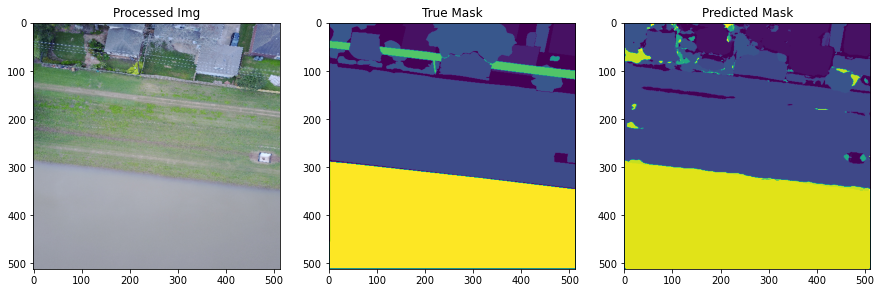

In [30]:


def visualise_test(image_name):

    img1 = np.array(PIL.Image.open(test_x_loc + image_name +'.jpg').resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
    img2 = mpimg.imread(test_y_loc + image_name +'.png')
    # mpimg.imread(test_x_loc + '6413.jpg')

    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(img1)
    axs[0].set_title('Processed Img')
    axs[1].imshow(img2)
    axs[1].set_title('Predicted img')
    
def visualise_train(image_name):

    img1 = np.array(PIL.Image.open(train_x_loc + image_name +'.jpg').resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
    img2 = np.array(PIL.Image.open(train_y_loc + image_name + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))
    # mpimg.imread(train_y_loc + image_name +'.png')
    # mpimg.imread(test_x_loc + '6413.jpg')

    img_name = [image_name]
    pred = get_predictions(train_x_loc,img_name)
    mask = create_mask(pred)
    print(mask.keys())
    img3 = mask[image_name]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(img1)
    axs[0].set_title('Processed Img')
    axs[1].imshow(img2)
    axs[1].set_title('True Mask')
    axs[2].imshow(img3)
    axs[2].set_title('Predicted Mask')
    
assert(model is not None)
# visualise_test('') # provide only image names from 'train_images'
visualise_train('6456') # provide only image names from 'test_images'